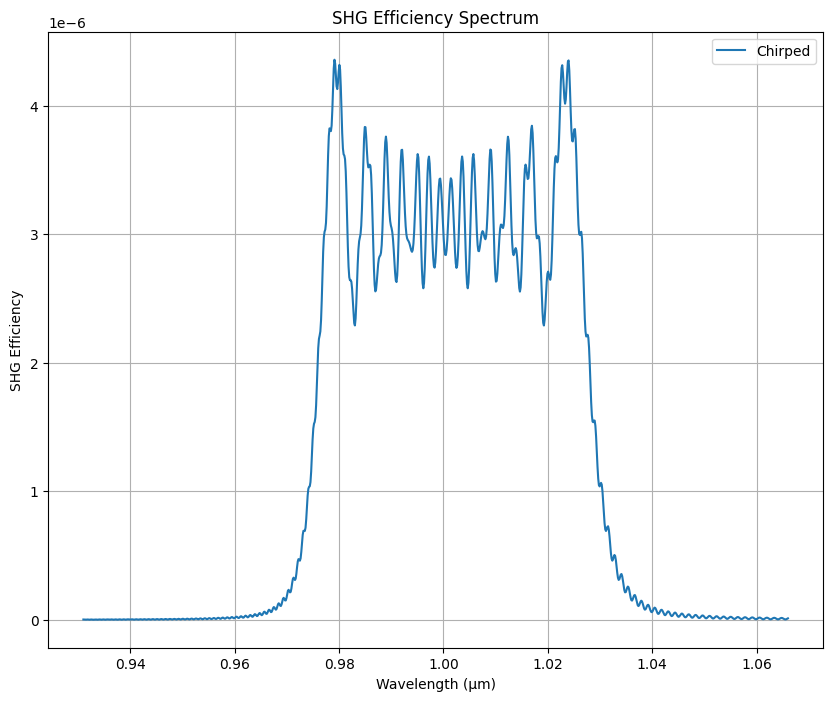

In [2]:
from syuron import shg
from syuron import mgoslt
from syuron import pp
import jax.numpy as jnp
import matplotlib.pyplot as plt


chirped_dim = pp.chirped(600, [3.6], 1.031E-05, [0.0001])
random_dim = pp.random(100, 101, 1.031E-05, 3.4, 3.6)
fixed_dim = pp.fixed(300, [3.6], 1.031E-05)

wavelength_dim = jnp.linspace(0.931, 1.066, 1000).tolist()

params = shg.Params(
    superlattice_dim=chirped_dim,
    T_dim=70,
    wavelength_dim=wavelength_dim,
    fund_power_dim=1,
    sh_power_dim=0,
)

eff_tensor = mgoslt.analyze(params)

plt.figure(figsize=(10, 8))
plt.plot(wavelength_dim, eff_tensor[0, 0, :, 0, 0], label="Chirped")
plt.xlabel("Wavelength (μm)")
plt.ylabel("SHG Efficiency")
plt.title("SHG Efficiency Spectrum")
plt.legend()
plt.grid(True)
plt.show()

データセットの入力の作成完了
計算が終了


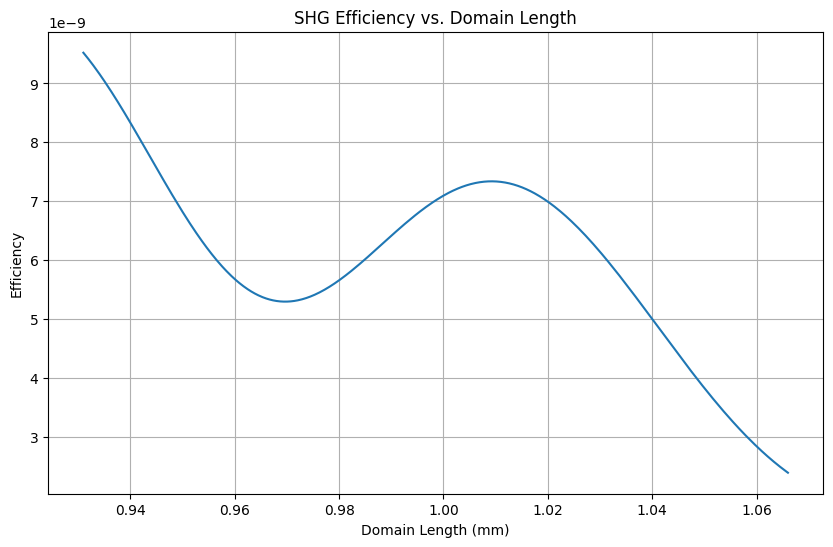

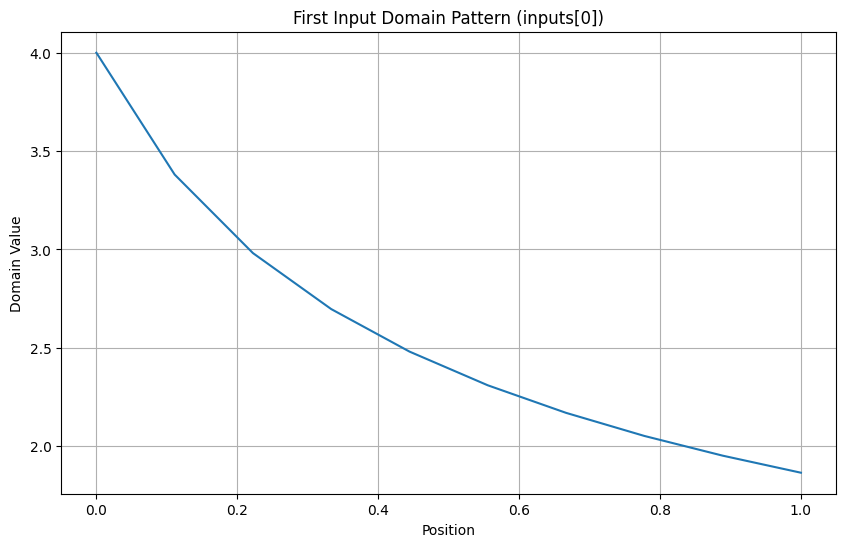

inputs shape: (100, 1000), outputs shape: (100, 10)
[(array([2.52359627e-08, 2.53139412e-08, 2.53908983e-08, 2.54678660e-08,
       2.55435495e-08, 2.56183164e-08, 2.56927670e-08, 2.57657007e-08,
       2.58378723e-08, 2.59087862e-08, 2.59801638e-08, 2.60502304e-08,
       2.61187960e-08, 2.61875215e-08, 2.62542681e-08, 2.63212989e-08,
       2.63866884e-08, 2.64519127e-08, 2.65153979e-08, 2.65782525e-08,
       2.66403166e-08, 2.67021303e-08, 2.67616826e-08, 2.68216098e-08,
       2.68798743e-08, 2.69374922e-08, 2.69939822e-08, 2.70504561e-08,
       2.71056173e-08, 2.71591372e-08, 2.72121916e-08, 2.72645284e-08,
       2.73157799e-08, 2.73657896e-08, 2.74154157e-08, 2.74635017e-08,
       2.75114882e-08, 2.75577197e-08, 2.76033951e-08, 2.76483245e-08,
       2.76916534e-08, 2.77342895e-08, 2.77763856e-08, 2.78172845e-08,
       2.78570980e-08, 2.78960837e-08, 2.79340266e-08, 2.79707795e-08,
       2.80071166e-08, 2.80420931e-08, 2.80760144e-08, 2.81092145e-08,
       2.81411996e-08, 

In [18]:
from syuron import shg
import jax.numpy as jnp
from syuron import pp
from syuron import mgoslt
from workspace import path
import matplotlib.pyplot as plt
import tensorflow as tf

num_start_width = 10
num_chirp_rate = 10
num_domains = 10
num_samples = num_chirp_rate * num_start_width
chirped_dim = pp.chirped(num_domains, jnp.linspace(
    3, 4, num_start_width).tolist(), 1.031E-05, jnp.linspace(0.01, 0.05, num_chirp_rate).tolist())

print("データセットの入力の作成完了")

wavelength_dim = jnp.linspace(0.931, 1.066, 1000).tolist()

params = shg.Params(
    superlattice_dim=chirped_dim,
    T_dim=70,
    wavelength_dim=wavelength_dim,
    fund_power_dim=1,
    sh_power_dim=0,
    mesh_density=100
)

eff_tensor = mgoslt.analyze(params)

print("計算が終了")

example_index = 100

# 代表的なデータの可視化
example_eff = eff_tensor[example_index, 0, :, 0, 0].tolist()
plt.figure(figsize=(10, 6))
plt.plot(wavelength_dim, example_eff)
plt.xlabel('Domain Length (mm)')
plt.ylabel('Efficiency')
plt.title('SHG Efficiency vs. Domain Length')
plt.grid(True)
plt.show()


# 代表的なグレーティング周期の可視化
x_axis = jnp.linspace(0, 1, num_domains).tolist()
plt.figure(figsize=(10, 6))
plt.plot(x_axis, chirped_dim[example_index, :, 0])  # Plot the first input domain pattern
plt.xlabel('Position')
plt.ylabel('Domain Value')
plt.title('First Input Domain Pattern (inputs[0])')
plt.grid(True)
plt.show()

inputs = eff_tensor[:, 0, :, 0, 0]
outputs = chirped_dim[:, :, 0]
print(f"inputs shape: {inputs.shape}, outputs shape: {outputs.shape}")

dataset = tf.data.Dataset.from_tensor_slices((inputs, outputs))
print(list(dataset.as_numpy_iterator())[:3])
output_path = path.Path("research/syuron/dataset/chirped.tfrecord").abs()
# dataset.save(output_path)

2025-03-18 06:33:14.860311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742279594.882360   65863 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742279594.888976   65863 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742279594.906526   65863 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742279594.906553   65863 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742279594.906554   65863 computation_placer.cc:177] computation placer alr

データセットの入力の作成完了
計算が終了


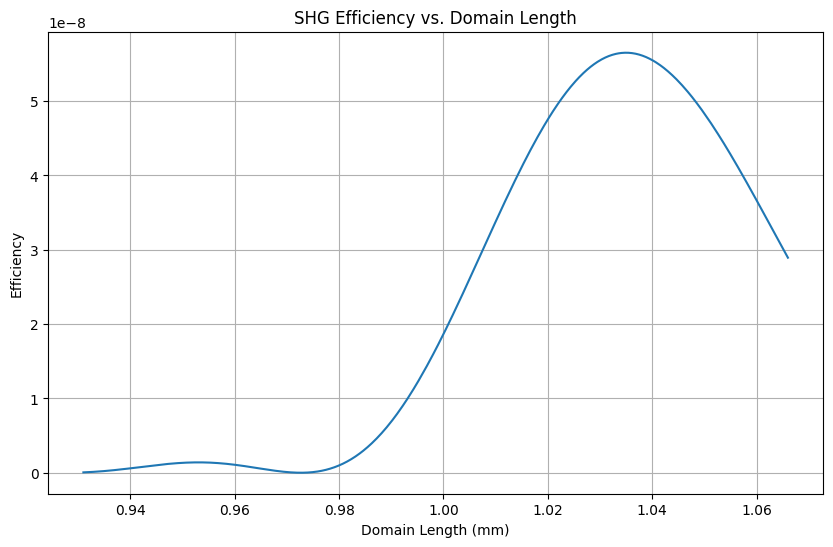

inputs shape: (1, 1000), outputs shape: (1, 10)


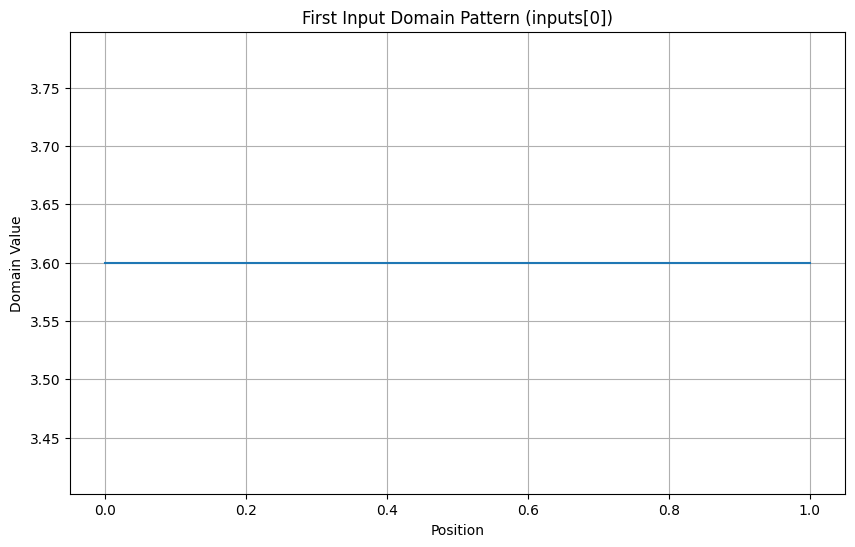

I0000 00:00:1742279603.595309   65863 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8850 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:af:00.0, compute capability: 8.6


[(array([4.89650057e-11, 5.27490482e-11, 5.66703524e-11, 6.07829551e-11,
       6.50202947e-11, 6.93943097e-11, 7.39497977e-11, 7.86122417e-11,
       8.34245173e-11, 8.83543169e-11, 9.35212047e-11, 9.88060675e-11,
       1.04188658e-10, 1.09796360e-10, 1.15460003e-10, 1.21373273e-10,
       1.27356486e-10, 1.33552308e-10, 1.39813952e-10, 1.46245044e-10,
       1.52823768e-10, 1.59619734e-10, 1.66400574e-10, 1.73469003e-10,
       1.80585685e-10, 1.87871899e-10, 1.95274616e-10, 2.02925177e-10,
       2.10665180e-10, 2.18440280e-10, 2.26406421e-10, 2.34538389e-10,
       2.42779324e-10, 2.51098559e-10, 2.59637062e-10, 2.68189998e-10,
       2.77023848e-10, 2.85835494e-10, 2.94835129e-10, 3.03992137e-10,
       3.13147341e-10, 3.22455285e-10, 3.31980332e-10, 3.41557643e-10,
       3.51218638e-10, 3.61026570e-10, 3.70914049e-10, 3.80843829e-10,
       3.91015859e-10, 4.01190553e-10, 4.11431805e-10, 4.21846447e-10,
       4.32284292e-10, 4.42818671e-10, 4.53445864e-10, 4.64199790e-10,
    

In [ ]:
from syuron import shg
import jax.numpy as jnp
from syuron import pp
from syuron import mgoslt
from workspace import path
import matplotlib.pyplot as plt
import tensorflow as tf

num_domains = 10
width_dim = [3.6]
num_samples = len(width_dim)
chirped_dim = pp.fixed(num_domains, width_dim, 1.031E-05)

print("データセットの入力の作成完了")

wavelength_dim = jnp.linspace(0.931, 1.066, 1000).tolist()

params = shg.Params(
    superlattice_dim=chirped_dim,
    T_dim=70,
    wavelength_dim=wavelength_dim,
    fund_power_dim=1,
    sh_power_dim=0,
    mesh_density=100
)

eff_tensor = mgoslt.analyze(params)

print("計算が終了")

example_index = 80

# 代表的なデータの可視化
example_eff = eff_tensor[example_index, 0, :, 0, 0].tolist()
plt.figure(figsize=(10, 6))
plt.plot(wavelength_dim, example_eff)
plt.xlabel('Domain Length (mm)')
plt.ylabel('Efficiency')
plt.title('SHG Efficiency vs. Domain Length')
plt.grid(True)
plt.show()

# 代表的なグレーティング周期の可視化
example_domain = chirped_dim[example_index, :, 0]
x_axis = jnp.linspace(0, 1, num_domains).tolist()
plt.figure(figsize=(10, 6))
plt.plot(x_axis, example_domain)  # Plot the first input domain pattern
plt.xlabel('Position')
plt.ylabel('Domain Value')
plt.title('First Input Domain Pattern (inputs[0])')
plt.grid(True)
plt.show()

inputs = eff_tensor[:, 0, :, 0, 0]
outputs = chirped_dim[:, :, 0]
print(f"inputs shape: {inputs.shape}, outputs shape: {outputs.shape}")

dataset = tf.data.Dataset.from_tensor_slices((inputs, outputs))
print(list(dataset.as_numpy_iterator())[:3])
output_path = path.Path("research/syuron/dataset/chirped.tfrecord").abs()
# dataset.save(output_path)